# Modelling Customer Satisfaction

##### The aim of this project is to model customer satisfaction for a logistics and delivery startup. The dataset we will be working with was collected via a customer satisfaction survey, and provided by the startup. Our goal is to create a model that predicts customer satisfaction given responses to the other questions in the survey. Furthermore, our aim is to create an easily interpretable model, so that the startup can learn where it needs to improve its service to boost customer satisfaction. 

Useful python libraries and functions to use later on

In [1]:
import random
seed = random.randint(1000,9999)
print(seed)

9329


In [1]:
seed = 9329

In [2]:
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import (
    make_scorer, precision_score, recall_score, roc_auc_score, f1_score, accuracy_score, classification_report,
    roc_curve, auc, precision_recall_curve, confusion_matrix)
from scipy.stats.distributions import loguniform
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

from lazypredict.Supervised import LazyClassifier

from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline  # combining classifier steps
from sklearn.preprocessing import StandardScaler # scaling features

import numpy as np
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score, make_scorer, precision_score
from hyperopt import space_eval
from sklearn.tree import export_text

from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier


In [3]:
#ROC curve drawing by using the helper function
def plot_roc_curve(roc):
    """
    Plots the ROC curve from a DataFrame.
    
    Parameters:
    - roc: DataFrame containing 'false positive rate', 'true positive rate', and 'threshold' columns.
    """
    plt.figure(figsize=(8, 6))
    plt.plot(roc['false positive rate'], roc['true positive rate'], label='ROC Curve')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')  # adding a 45-degree dashed line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

In [4]:
def pretty_confusion_matrix(confmat, labels, title, labeling=False, highlight_indexes=[]):
    '''
    Plots the confusion matrix, given relevant data.
    '''
    labels_list = [["TN", "FP"], ["FN", "TP"]]
    
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            if labeling:
                label = str(confmat[i, j])+" ("+labels_list[i][j]+")"
            else:
                label = confmat[i, j]
            
            
            if [i,j] in highlight_indexes:
                ax.text(x=j, y=i, s=label, va='center', ha='center',
                        weight = "bold", fontsize=18, color='#32618b')
            else:
                ax.text(x=j, y=i, s=label, va='center', ha='center')
       
    # change the labels
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        ax.set_xticklabels(['']+[labels[0], labels[1]])
        ax.set_yticklabels(['']+[labels[0], labels[1]])

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    ax.xaxis.set_label_position('top')
    plt.suptitle(title)
    plt.tight_layout()
    
    plt.show()

In [5]:
from matplotlib.patches import Patch

def plot_coefs(all_coeffs, order, title):
    '''
    Function for plotting a barplot of the coefficients of the fitted model.
    Will be used in logistic regression model.
    '''
    # setting colors for positive and negative coefficients.
    colors = ['red' if value > 0 else 'blue' for value in all_coeffs]
    
    plt.bar(range(len(all_coeffs)),all_coeffs, align='center', color=colors)
    plt.xticks(range(len(order)), order, size='small',rotation = 70)
    plt.tight_layout
    # Create custom legend entries
    legend_handles = [
        Patch(color='red', label='Positive'),
        Patch(color='blue', label='Negative')
    ]
    
    plt.legend(handles=legend_handles)
    
    # Set labels and title
    plt.xlabel('Features')
    plt.ylabel('Coefficient Value')
    plt.title(title)

In [6]:
def plot_feature_importance(model, names, threshold = None):
    feature_importance_df = pd.DataFrame.from_dict({'feature_importance': model.feature_importances_[:len(names)],
                                                    'feature': names})\
            .set_index('feature').sort_values('feature_importance', ascending = False)

    if threshold is not None:
        feature_importance_df = feature_importance_df[feature_importance_df.feature_importance > threshold]

    feature_importance_df.plot(kind="barh")
    fig.show()



#### **EDA**

Description of data

Y = target attribute (Y) with values indicating 0 (unhappy) and 1 (happy) customers\
X1 = my order was delivered on time\
X2 = contents of my order was as I expected\
X3 = I ordered everything I wanted to order\
X4 = I paid a good price for my order\
X5 = I am satisfied with my courier\
X6 = the app makes ordering easy for me

Attributes X1 to X6 indicate the responses for each question and have values from 1 to 5 where the smaller number indicates less and the higher number indicates more towards the answer.

Thus, in this project, we are dealing with a classification problem. Our target variable is Y and our feature variables are X1 to X6.


In [7]:
import pandas as pd
df = pd.read_csv("ACME-HappinessSurvey2020.csv")
df.head()

,Y,X1,X2,X3,X4,X5,X6
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Y       126 non-null    int64
 1   X1      126 non-null    int64
 2   X2      126 non-null    int64
 3   X3      126 non-null    int64
 4   X4      126 non-null    int64
 5   X5      126 non-null    int64
 6   X6      126 non-null    int64
dtypes: int64(7)
memory usage: 7.0 KB


##### Comments

Above we see that the dataset consists of 126 data points. Thus, we are working with a relatively small dataset. Fortunately, there appear to be no null values in the dataset.

In [9]:
df.describe()

,Y,X1,X2,X3,X4,X5,X6
count,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000
mean,0.547619,4.333333,2.531746,3.309524,3.746032,3.650794,4.253968
std,0.499714,0.800000,1.114892,1.023440,0.875776,1.147641,0.809311
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,4.000000,2.000000,3.000000,3.000000,3.000000,4.000000
50%,1.000000,5.000000,3.000000,3.000000,4.000000,4.000000,4.000000
75%,1.000000,5.000000,3.000000,4.000000,4.000000,4.000000,5.000000
max,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


##### Comments

Above we see that the mean of the target variable is approximately 0.548. Thus, it appears that there is a fairly even split between Y = 0 and Y = 1 cases. Therefore, the dataset does not appear to be imbalanced. The distribution of the features (X1-X6) is less clear from the table above. Below, we will plot the distributions.

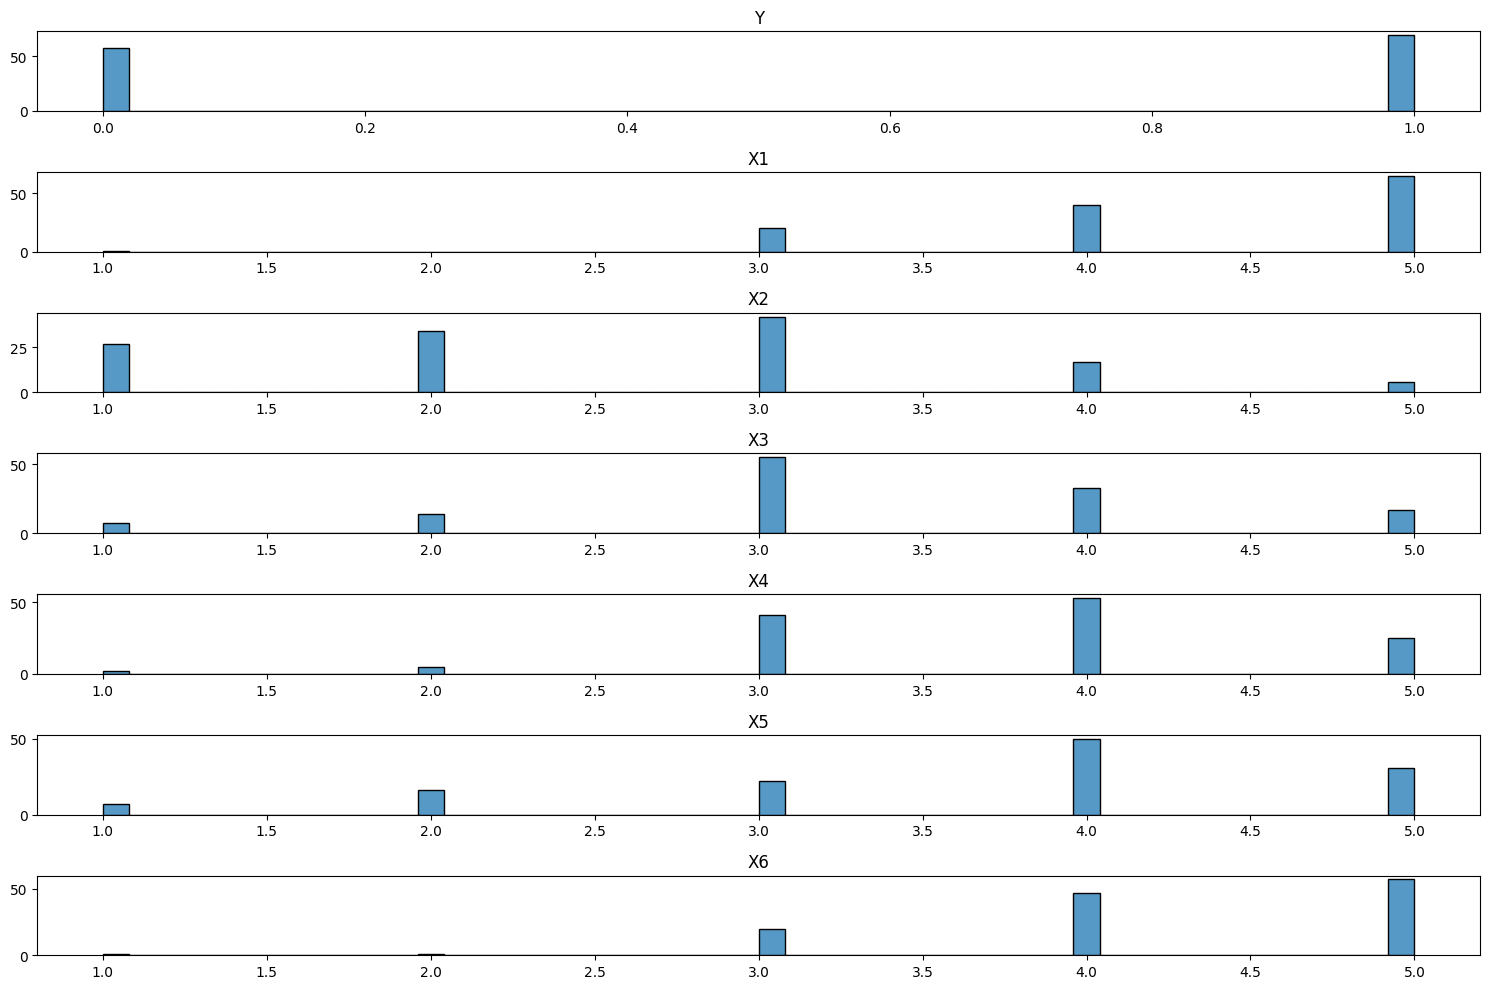

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns


fig, axes = plt.subplots(figsize=(15,10), ncols=1, nrows=7)
axes = axes.flatten()

for i, ax in enumerate(axes):
    sns.histplot(data = df.iloc[:, i], bins=50, ax=ax)
    ax.set_title(df.iloc[:,i].name)
    ax.set_ylabel("")
    ax.set_xlabel("")

plt.tight_layout()
plt.show()

##### Comments

The first thing to note is that the scale of all our feature variables is the same (1-5). Above, we can clearly see that the distributions of the X1, X4, X5 and X6 variables are skewed to the right. The distribution of the X2 is slightly skewed to the left. The distribution of the X3 variable is most normally distributed.

Furthermore, we can note that there are very few instances of X1 = 1,2 and X6 = 1,2. Below, we calculate the exact number of these instances.


In [11]:
df["X1"].value_counts()

X1
5    65
4    40
3    20
1     1
Name: count, dtype: int64

In [12]:
df["X6"].value_counts()

X6
5    57
4    47
3    20
2     1
1     1
Name: count, dtype: int64

##### Correlation Table

Below we plot the correlation heatmap. Interestingly, there are no two variables which appear strongly correlated. The hightest correlation coefficient value in the heatmap is only 0.43 (between X1 and X5). Therefore, no clear relationship between any two variables stands out in this heatmap. Looking at the row corresponding to Y, we see that the correlation coefficients between Y and X2, and Y and X4 are particularly close to zero.

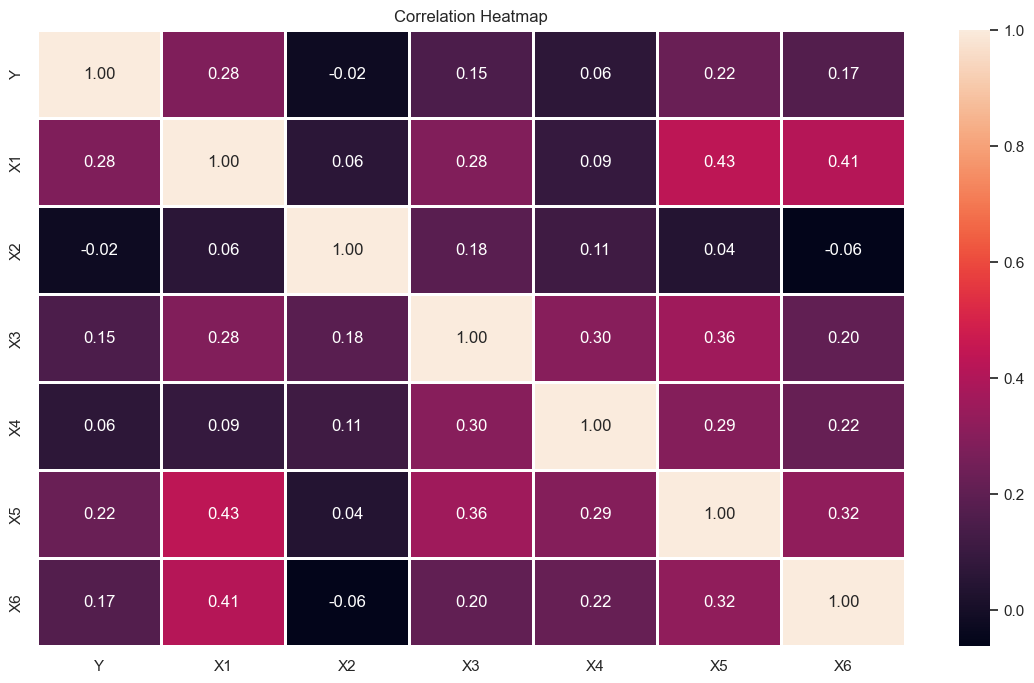

In [13]:
sns.set(rc={'figure.figsize': (14, 8)})
sns.heatmap(df.corr(), annot = True, fmt = '.2f', linewidths = 2)
plt.title("Correlation Heatmap")
plt.show()

#### **EDA Comments**

From the EDA, we have learned a lot about the dataset. One of the most important takeaways is that the startup is performing poorly. The number of dissatisfied and satisfied customers is fairly evenly split. Thus, it is imperative that the startup improves customer satisfaction. To this end, we will design a classification machine learning model which will attempt to model customer satisfaction given values of the feature variables.

Below is a table describing the main takeaways from the EDA, with their corresponding consequences for our models.

| Issue    | Consequences for Model |
|----------|----------|
| Fairly even split between Y = 0 and Y = 1 cases | As dataset is balanced, there is no need to perform upsampling. Furthermore, recall for unhappy customers should be used as model score to optimize, as it is imperative that we classify unhappy customers correctly, to understand what is driving their discontent.  |
| Feature variables are all on same scale (1-5) | No need to perform feature engineering on feature scale |
| Few instances of X1 = 1,2 and X6 = 1,2 | Consider removing these datapoints, as they could cause issues down the line | 
| Correlation coefficients between Y and X2, and Y and X4 are close to zero | Consider removing features X2 and/or X4, to make feature space smaller | 

#### **Data Clean Up and Feature Engineering**

In our EDA, we saw that the dataset was fairly straightforward and required little clean up or feature engineering. The only potential feature engineering step that could be included in our model pipelines is to remove the feature variables X2 and/or X4. Below, we will try three cases: with X2 and X4, without X2, and without X2 and X4. 

In [ ]:
'''
X = df.drop('Y', axis = 1)
Y = df["Y"].copy()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify = Y, random_state=seed)

X_train_ = X_train.drop('X2', axis = 1)
X_test_ = X_test.drop('X2', axis = 1)

X_train_red = X_train_.drop('X4', axis = 1)
X_test_red = X_test_.drop('X4', axis = 1)
'''



Classification models can exhibit high degrees of sensitivity to training and test datasets, when working with small datasets. As our dataset is small, it is adviseable to save the test and training datasets, so that the same sets are used each time for every model.

In [36]:
'''
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)


X_train.to_csv("X_train.csv", index=False)
X_test.to_csv("X_test.csv", index=False)
y_train.to_csv("y_train.csv", index=False, header=True)
y_test.to_csv("y_test.csv", index=False, header=True)

X_train_.to_csv("X_train_.csv", index=False)
X_test_.to_csv("X_test_.csv", index=False)

X_train_red.to_csv("X_train_red.csv", index=False)
X_test_red.to_csv("X_test_red.csv", index=False)

'''


Reading datasets

In [7]:
import pandas as pd

X_train = pd.read_csv("X_train.csv")
X_test = pd.read_csv("X_test.csv")

y_train = pd.read_csv("y_train.csv").squeeze("columns")  # Use `squeeze=True` to load as Series
y_test = pd.read_csv("y_test.csv").squeeze("columns")



#### Lazy Predict

To gain some idea as to which classification models will likely perform better for our dataset, we will use Lazy Predict. 

##### Full dataset

In [48]:


# Define specificity function
def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp) if (tn + fp) > 0 else 0

# Initialize LazyClassifier with the custom specificity function
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=specificity_score)

# Fit models and get results
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

# Display results
print(models)



  0%|          | 0/32 [00:00<?, ?it/s]

100%|██████████| 32/32 [00:02<00:00, 12.65it/s]

[LightGBM] [Info] Number of positive: 55, number of negative: 45
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000166 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31
[LightGBM] [Info] Number of data points in the train set: 100, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.550000 -> initscore=0.200671
[LightGBM] [Info] Start training from score 0.200671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

##### Dataset without X2 feature

In [49]:
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=specificity_score)
models, predictions = clf.fit(X_train_, X_test_, y_train, y_test)

print(models)

  0%|          | 0/32 [00:00<?, ?it/s]

100%|██████████| 32/32 [00:02<00:00, 11.92it/s]

[LightGBM] [Info] Number of positive: 55, number of negative: 45
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25
[LightGBM] [Info] Number of data points in the train set: 100, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.550000 -> initscore=0.200671
[LightGBM] [Info] Start training from score 0.200671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

##### Dataset without X2 and X4 features

In [50]:
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=specificity_score)
models, predictions = clf.fit(X_train_red, X_test_red, y_train, y_test)

print(models)

100%|██████████| 32/32 [00:02<00:00, 12.99it/s]

[LightGBM] [Info] Number of positive: 55, number of negative: 45
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20
[LightGBM] [Info] Number of data points in the train set: 100, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.550000 -> initscore=0.200671
[LightGBM] [Info] Start training from score 0.200671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

##### **Analysis of Lazy Predict Results**

Above, we have seen that the optimal model depends on the dataset. Furthermore, we have seen that working with a reduced dataset (without X2 and X4 feature) appears to improve model performance according to the accuracy, roc auc and F1 scores. However, there is a less significant improvement in model performance if we look at the specififity/negative recall score. As stated previously, as the main goal of the project is to identify unhappy customers, the specificity/negative recall score will be the main score we will be working with. Furthermore, it is worth noting that none of the models appear to perform that well according to the predictions of Lazy Predict. Thus, the problem at hand is non-trivial. 

As working with any of the two reduced datasets above appears to offer minimal improvement in specificity/negative recall scores, it would be unwise at the point to work with these reduced datasets. Therefore, we will continue working with the full dataset. However, later on when we examine our best performing models, we will implement Recursive Feature Elimination to see whether a different reduced dataset offers any advantages. This way we can gauge which of our features are the most important for predicting customer satisfaction. 

Given the time constraints of the project, it is not possible to investigate all the permutations of the different models and datasets. After consulting the top performing models in the above tables, I note that tree models are common. Thus it makes sense to mostly work with these types of models. We will work with a decision tree model (which can be viewed as our baseline model) and bagging classifier. It is worth noting that we will not present random forest and Adaboost models here, as after initial tests with these models, they appeared to perform poorly. Furthermore, to not have all our eggs in one basket, we will work with other models that aren't tree models. After consulting the results above, we note that the BernoulliNB and Logistic Regression models score well. Thus, we will also work with a Naive Bayes classifier and a Logistic Regression model. 

#### **Decision Tree Model**

In [9]:

# Define the custom scorer focusing on negative recall
negative_recall = make_scorer(recall_score, pos_label=0)
# Define the custom scorer focusing on negative recall
negative_precision = make_scorer(precision_score, pos_label=0)


Let us first try fitting the model without performing RFE or hyperparameter optimization. random_state is set to seed for reproducibility.

In [10]:

dt_pipeline = Pipeline(steps=[('model', DecisionTreeClassifier(random_state=seed))])

dt_pipeline.fit(X_train,y_train)

tree_text = export_text(dt_pipeline[-1], feature_names=X_train.columns, max_depth=3)
print(tree_text)


|--- X1 <= 4.50
|   |--- X6 <= 3.50
|   |   |--- X3 <= 3.50
|   |   |   |--- class: 0
|   |   |--- X3 >  3.50
|   |   |   |--- X1 <= 3.50
|   |   |   |   |--- class: 1
|   |   |   |--- X1 >  3.50
|   |   |   |   |--- class: 0
|   |--- X6 >  3.50
|   |   |--- X3 <= 3.50
|   |   |   |--- X1 <= 2.00
|   |   |   |   |--- class: 0
|   |   |   |--- X1 >  2.00
|   |   |   |   |--- truncated branch of depth 7
|   |   |--- X3 >  3.50
|   |   |   |--- X2 <= 2.50
|   |   |   |   |--- truncated branch of depth 3
|   |   |   |--- X2 >  2.50
|   |   |   |   |--- class: 0
|--- X1 >  4.50
|   |--- X3 <= 3.50
|   |   |--- X6 <= 4.50
|   |   |   |--- X3 <= 2.50
|   |   |   |   |--- class: 1
|   |   |   |--- X3 >  2.50
|   |   |   |   |--- truncated branch of depth 4
|   |   |--- X6 >  4.50
|   |   |   |--- X3 <= 2.50
|   |   |   |   |--- class: 0
|   |   |   |--- X3 >  2.50
|   |   |   |   |--- truncated branch of depth 6
|   |--- X3 >  3.50
|   |   |--- X4 <= 2.50
|   |   |   |--- X5 <= 3.50
|   |   | 

In [15]:
def all_results(pipeline, X_test, y_train, y_test):

    y_probs = pipeline.predict_proba(X_test)[:, 1]
    y_pred = pipeline.predict(X_test)

    # get the confusion matrix as a numpy array
    confmat = confusion_matrix(y_true = y_test, y_pred = y_pred)
    # use the pretty function to make it nicer

    LE = LabelEncoder()
    y_train = LE.fit_transform(y_train)
    y_test = LE.transform(y_test)
    FP_i = [0,1]
    TN_i = [0,0]
    TP_i = [1,1]
    FN_i = [1,0]

    # Extracting the quantities from the confusion matrix 
    FP = confmat[0,1]
    TN = confmat[0,0]
    TP = confmat[1,1]
    FN = confmat[1,0]

    #Calculation of FPR, Recall, Precision, F1 Score, ROC_AUC, Accuracy
    # FPR
    FPR = (FP)/(FP+TN)
    # Recall
    Recall = (TP)/(TP+FN)
    Negative_Recall = (TN)/(TN+FP)

    # Precision
    Precision = (TP)/(FP+TP)
    # F1 Score
    F1 = 2 * (Precision * Recall)/(Precision + Recall)

    AUC = roc_auc_score(y_true = y_test, y_score = y_probs)

    accuracy = (TN+TP)/(TN+TP+FN+FP)

    print(classification_report(y_test, y_pred))

    pretty_confusion_matrix(confmat, LE.classes_, "",
                            labeling=True, highlight_indexes = [FP_i,FN_i,TP_i,TN_i])

    print('False Positive Rate (FPR): '+ '%.3f' % FPR)
    print('Recall: '+ '%.3f' % Recall)
    print('Negative Recall: '+'%.3f' % Negative_Recall)
    print('Precision: '+ '%.3f' % Precision)
    print('F1 Score: '+ '%.3f' % F1)
    print(f'ROC AUC = {AUC}')
    print(f'Accuracy = {accuracy}')

    return FPR, Recall, Negative_Recall, Precision, AUC, accuracy


Below are the performance scores of the decision tree model on the test data. As we can see, the model performs fairly well. The negative recall score is 0.67, which means that the model correctly classifies unhappy customers 67% of the time. Furthermore, the model correctly classifies happy customers 57% of the time. Therefore, the model, on the whole, performs fairly well, with an accuracy of 62%. However, as the goal of the project is to create a model with 70+% accuracy, we will try to improve upon this model.

              precision    recall  f1-score   support

           0       0.57      0.67      0.62        12
           1       0.67      0.57      0.62        14

    accuracy                           0.62        26
   macro avg       0.62      0.62      0.62        26
weighted avg       0.62      0.62      0.62        26



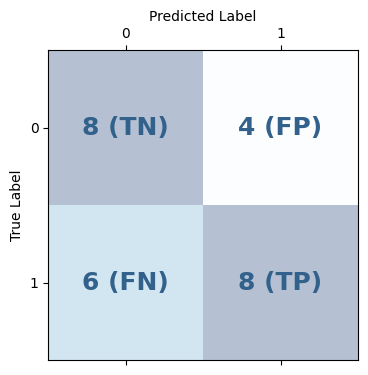

False Positive Rate (FPR): 0.333
Recall: 0.571
Negative Recall: 0.667
Precision: 0.667
F1 Score: 0.615
ROC AUC = 0.630952380952381
Accuracy = 0.6153846153846154


In [14]:
FPR, Recall, Negative_Recall, Precision, AUC, accuracy = all_results(dt_pipeline, X_test, y_train, y_test)

Below I have plotted the relative feature importance of each model. As we can see, X1 and X3 features stand out as the most important features in the model. Thus, it may be advantageous to perform RFE on this model, to see whether a better performing model with fewer features can be constructed.

NameError: name 'fig' is not defined

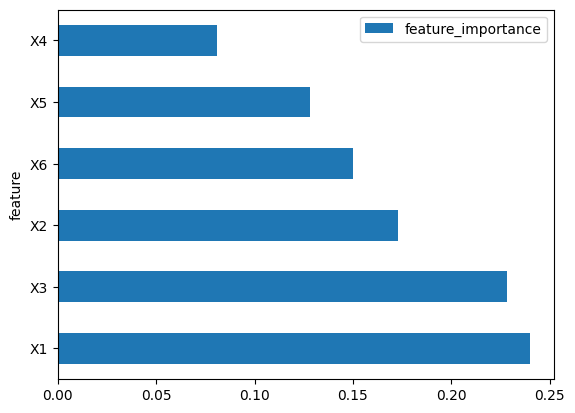

In [27]:
plot_feature_importance(dt_pipeline[-1], X_train.columns)

#### RFE

Below, we have calculated the performance scores of the decision tree models with reduced variables, using RFE. As we can see, the models with just 1 and 2 features perform equally well or better than our baseline model with all variables (according to negative recall score). Therefore, it again appears that RFE can offer advantages to our model. We will therefore perform a hyperparameter optimization, including number of features as a hyperparameter to optimize over.

              precision    recall  f1-score   support

           0       0.50      0.75      0.60        12
           1       0.62      0.36      0.45        14

    accuracy                           0.54        26
   macro avg       0.56      0.55      0.53        26
weighted avg       0.57      0.54      0.52        26



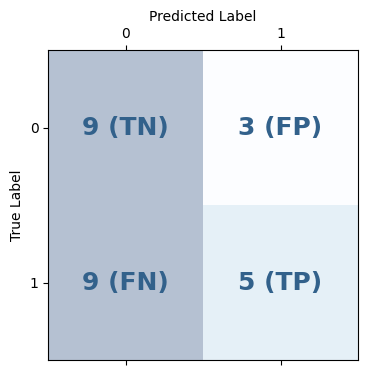

False Positive Rate (FPR): 0.250
Recall: 0.357
Negative Recall: 0.750
Precision: 0.625
F1 Score: 0.455
ROC AUC = 0.5714285714285714
Accuracy = 0.5384615384615384
              precision    recall  f1-score   support

           0       0.57      0.67      0.62        12
           1       0.67      0.57      0.62        14

    accuracy                           0.62        26
   macro avg       0.62      0.62      0.62        26
weighted avg       0.62      0.62      0.62        26



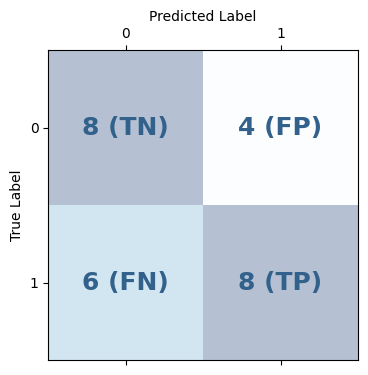

False Positive Rate (FPR): 0.333
Recall: 0.571
Negative Recall: 0.667
Precision: 0.667
F1 Score: 0.615
ROC AUC = 0.6071428571428572
Accuracy = 0.6153846153846154
              precision    recall  f1-score   support

           0       0.50      0.50      0.50        12
           1       0.57      0.57      0.57        14

    accuracy                           0.54        26
   macro avg       0.54      0.54      0.54        26
weighted avg       0.54      0.54      0.54        26



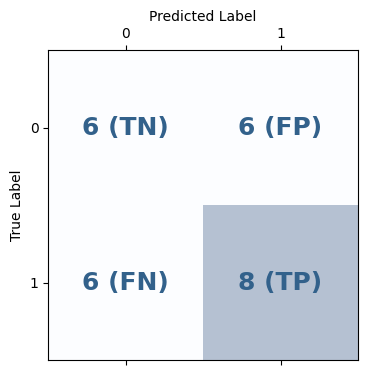

False Positive Rate (FPR): 0.500
Recall: 0.571
Negative Recall: 0.500
Precision: 0.571
F1 Score: 0.571
ROC AUC = 0.6011904761904763
Accuracy = 0.5384615384615384
              precision    recall  f1-score   support

           0       0.54      0.58      0.56        12
           1       0.62      0.57      0.59        14

    accuracy                           0.58        26
   macro avg       0.58      0.58      0.58        26
weighted avg       0.58      0.58      0.58        26



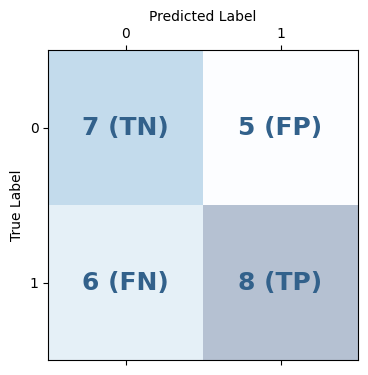

False Positive Rate (FPR): 0.417
Recall: 0.571
Negative Recall: 0.583
Precision: 0.615
F1 Score: 0.593
ROC AUC = 0.5416666666666667
Accuracy = 0.5769230769230769
              precision    recall  f1-score   support

           0       0.46      0.50      0.48        12
           1       0.54      0.50      0.52        14

    accuracy                           0.50        26
   macro avg       0.50      0.50      0.50        26
weighted avg       0.50      0.50      0.50        26



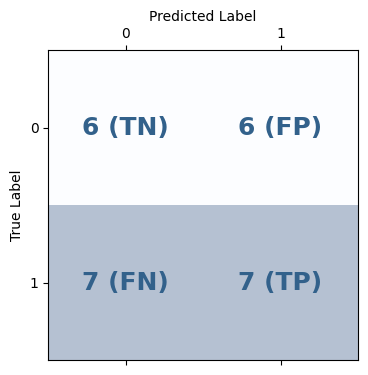

False Positive Rate (FPR): 0.500
Recall: 0.500
Negative Recall: 0.500
Precision: 0.538
F1 Score: 0.519
ROC AUC = 0.5357142857142857
Accuracy = 0.5


,n_features,FPR,Recall,Negative Recall,Precision,ROC AUC,Accuracy
0,1,0.25,0.36,0.75,0.62,0.57,0.54
1,2,0.33,0.57,0.67,0.67,0.61,0.62
2,3,0.50,0.57,0.50,0.57,0.60,0.54
3,4,0.42,0.57,0.58,0.62,0.54,0.58
4,5,0.50,0.50,0.50,0.54,0.54,0.50


In [ ]:
classifier_for_rfe = DecisionTreeClassifier(random_state=seed)


n_features_arr = np.array([1,2,3,4,5])

rfe_results = pd.DataFrame(columns=['n_features','FPR','Recall', 'Negative Recall', 'Precision', 'ROC AUC', 'Accuracy'])

for i,n_feature in enumerate(n_features_arr):

    rfe = RFE(estimator=classifier_for_rfe, n_features_to_select=n_feature)

    classifier_final = DecisionTreeClassifier(random_state=seed)

    # Create a pipeline that first does feature selection, then classification
    pipeline = Pipeline(steps=[('rfe', rfe), ('clf', classifier_final)])

    pipeline.fit(X_train,y_train)

    FPR, Recall, Negative_Recall, Precision, AUC, accuracy = all_results(pipeline, X_test, y_train, y_test)

    row = {'n_features': n_feature, 'FPR': FPR,'Recall': Recall,'Negative Recall': Negative_Recall,'Precision': Precision,'ROC AUC': AUC,'Accuracy': accuracy }
    # Convert the row to a DataFrame and concatenate
    rfe_results = pd.concat([rfe_results, pd.DataFrame([row])], ignore_index=True)
rfe_results



#### Hyperparameter optimization

Below, we perform hyperparameter optimization, including number of features as a hyperparameter. We use negative recall for our scoring in cross validation.

In [37]:


# Define the objective function
def objective(params):
    # the number of features, ensuring it is an integer
    n_features = int(params['n_features'])
    
    # Set up classifier hyperparameters 
    dt_params = {
        'max_depth': int(params['max_depth']),
        'min_samples_split': int(params['min_samples_split']),
        'min_samples_leaf': int(params['min_samples_leaf']),
        'class_weight': params['class_weight'],
        'criterion': params['criterion'],
        'random_state': int(params['random_state']),
    }


    classifier_for_rfe = DecisionTreeClassifier(**dt_params)
    
    # Set up the RFE with the classifier as the estimator
    rfe = RFE(estimator=classifier_for_rfe, n_features_to_select=n_features)
    
    classifier_final = DecisionTreeClassifier(**dt_params)

    # Create a pipeline that first does feature selection, then classification
    pipeline = Pipeline(steps=[('rfe', rfe), ('clf', classifier_final)])
    
    # Use cross-validation to evaluate performance using negative recall
    score = cross_val_score(pipeline, X_train, y_train, scoring=negative_recall, cv=5).mean()
    
    # Hyperopt minimizes the objective, so return the negative score (to maximize negative recall)
    return {'loss': -score, 'status': STATUS_OK}

# Define the hyperparameter search space using hp.choice for discrete parameters
search_space = {
    'n_features': hp.choice('n_features', list(np.arange(1, 6, 1, dtype=int))),
    'max_depth': hp.choice('max_depth', list(np.arange(3, 15, 1, dtype=int))),
    'min_samples_split': hp.choice('min_samples_split', list(np.arange(2, 10, 1, dtype=int))),
    'min_samples_leaf': hp.choice('min_samples_leaf', list(np.arange(1, 8, 1, dtype=int))),
    'class_weight': hp.choice('class_weight', [None, "balanced"]),
    'criterion': hp.choice('criterion', ["gini", "entropy"]),
    'random_state': hp.choice('random_state', [seed])  # Ensure 'seed' is defined
}

# Run Hyperopt
trials = Trials()
best = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=1000,
    trials=trials
)

best_params = space_eval(search_space, best)
print("Best hyperparameters:", best_params)


  0%|          | 0/1000 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 1000/1000 [02:38<00:00,  6.31trial/s, best loss: -0.8222222222222222]
Best hyperparameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': np.int64(3), 'min_samples_leaf': np.int64(1), 'min_samples_split': np.int64(5), 'n_features': np.int64(3), 'random_state': 9329}


Below, we save the optimal hyperparmaters. The optimal feature combination is printed, which corresponds to X1, X3 and X6. As X1 and X3 were the most important features in the baseline model, it appears that the hyperparameter optimization is working as we'd expect, creating a model with the most influential features.

In [ ]:
best_params_dtc = {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': np.int64(3), 'min_samples_leaf': np.int64(1), 'min_samples_split': np.int64(5), 'n_features': np.int64(3), 'random_state': 9329}

n_features_dtc = int(best_params_dtc['n_features'])
del best_params_dtc['n_features']



classifier_for_rfe = DecisionTreeClassifier(**best_params_dtc)
    
# Set up the RFE with the classifier as the estimator
rfe = RFE(estimator=classifier_for_rfe, n_features_to_select=n_features_dtc)

classifier_final = DecisionTreeClassifier(**best_params_dtc)


# Create a pipeline that first does feature selection, then classification
dtc_pipeline = Pipeline(steps=[('rfe', rfe), ('clf', classifier_final)])
dtc_pipeline.fit(X_train, y_train)


mask = dtc_pipeline.named_steps['rfe'].support_
selected_feature_names = X_train.columns[mask]
print("Selected features:", selected_feature_names)



Selected features: Index(['X1', 'X3', 'X6'], dtype='object')


Visualizing tree

In [39]:
from sklearn.tree import export_text
tree_text = export_text(dtc_pipeline[-1], feature_names=selected_feature_names, max_depth=3)
print(tree_text)

|--- X1 <= 4.50
|   |--- X6 <= 3.50
|   |   |--- X3 <= 3.50
|   |   |   |--- class: 0
|   |   |--- X3 >  3.50
|   |   |   |--- class: 0
|   |--- X6 >  3.50
|   |   |--- X3 <= 4.50
|   |   |   |--- class: 0
|   |   |--- X3 >  4.50
|   |   |   |--- class: 0
|--- X1 >  4.50
|   |--- X3 <= 3.50
|   |   |--- X6 <= 4.50
|   |   |   |--- class: 1
|   |   |--- X6 >  4.50
|   |   |   |--- class: 0
|   |--- X3 >  3.50
|   |   |--- X6 <= 4.50
|   |   |   |--- class: 1
|   |   |--- X6 >  4.50
|   |   |   |--- class: 1



The results for the model are given below. As we can see, the model performs particularly well according to the negative recall score (0.917). Therefore, our model correctly classifies unhappy customers 91.7% of the time. However, it also misclassifies happy customers 78.6% of the time. Therefore, the overall accuracy of the model is 54%. Thus, while this model performs well according to the negative recall score, it could be improved upon by misclassifying fewer happy customers as unhappy.

              precision    recall  f1-score   support

           0       0.50      0.92      0.65        12
           1       0.75      0.21      0.33        14

    accuracy                           0.54        26
   macro avg       0.62      0.57      0.49        26
weighted avg       0.63      0.54      0.48        26



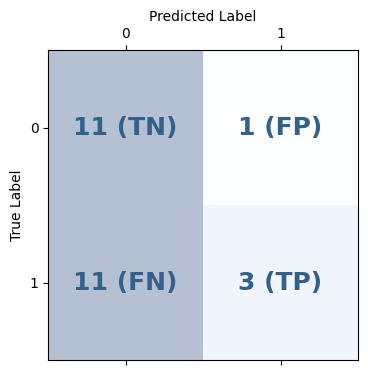

False Positive Rate (FPR): 0.083
Recall: 0.214
Negative Recall: 0.917
Precision: 0.750
F1 Score: 0.333
ROC AUC = 0.6011904761904762
Accuracy = 0.5384615384615384


In [ ]:
FPR, Recall, Negative_Recall, Precision, AUC, accuracy = all_results(dtc_pipeline, X_test, y_train, y_test)

results maximizing for diff quantities

seed = 7980
- neg recall --> almost all points classified as negative. False Positive Rate (FPR): 0.083, Recall: 0.214, Negative Recall: 0.917, Precision: 0.750, F1 Score: 0.333, accuracy = 0.62
- accuracy --> False Positive Rate (FPR): 0.500, Recall: 0.357, Negative Recall: 0.500, Precision: 0.455, F1 Score: 0.400, accuracy = 0.43.
- f1 --> False Positive Rate (FPR): 0.333, Recall: 0.500, Negative Recall: 0.667, Precision: 0.636, F1 Score: 0.560, accuracy: 0.59
- negative_precision --> False Positive Rate (FPR): 0.500, Recall: 0.357, Negative Recall: 0.500, Precision: 0.455, F1 Score: 0.400, accuracy: 0.43.

seed = 9329
- neg_recall = False Positive Rate (FPR): 0.083, Recall: 0.214, Negative Recall: 0.917, Precision: 0.750, F1 Score: 0.333, ROC AUC = 0.6011904761904762, Accuracy = 0.5384615384615384
- f1 --> terrible


Below, the relative feature importance in the model are plotted. As can be seen, all features appear to be similarly important. X3 seems to be marginally more important than the other two.

NameError: name 'fig' is not defined

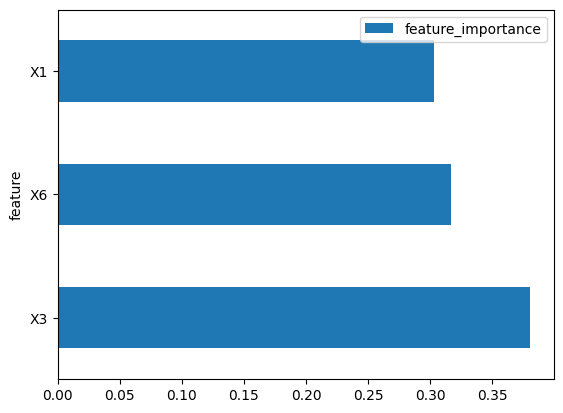

In [41]:

plot_feature_importance(dtc_pipeline[-1], selected_feature_names)

ROC curve plotted below.

AUC value: 0.6011904761904762


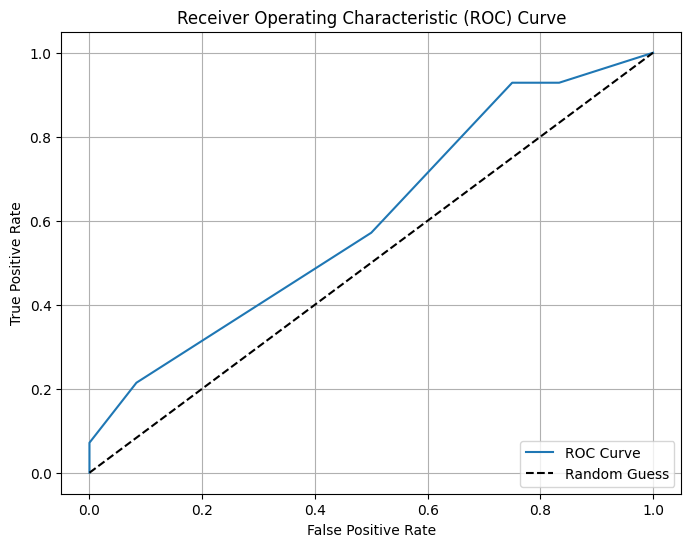

In [45]:
predictions_pa = dtc_pipeline.predict_proba(X_test)

roc_calc = roc_curve(y_true = y_test, y_score = predictions_pa[:,1])
roc = pd.DataFrame(
    data = np.c_[roc_calc],
    columns = ('false positive rate', 'true positive rate', 'threshold')
)
print("AUC value:", roc_auc_score(y_true = y_test, y_score = predictions_pa[:,1]))

# Compute precision-recall curve
baseline_precision, baseline_recall, thresholds = precision_recall_curve(y_test, predictions_pa[:,1])

# Compute area under the curve (AUC)
baseline_auc_score = auc(baseline_recall, baseline_precision)

plot_roc_curve(roc)

##### Summary of Decision Tree Model Findings

In this section, we have seen that, in our baseline decision tree model with all of our features, the model performed fairly well. Examining the relative importance of each feature, X1 and X3 (order delivered on time, and customer order everything they wanted to order), stood out as the two most important features. Inspired by this find, we tried to construct models in a reduced variable space using RFE. By performing a hyperparameter optimization, we found that a model with X1, X3 and X6 as features worked particularly well at correctly classifying negative cases. Therefore, a model with fewer features can work equally well / better than a model with all features. This implies that a few features (most evidently X1 and X3) are the main features to consider when modelling customer satisfaction.



#### **Bagging Model**

As a continuation of the decision tree model, we will implement a bagging classifier model. We will first try implementing a bagging classifier without performing hyperparameter optimization.

In [ ]:
bag_pipeline = Pipeline(steps=[('model', BaggingClassifier(estimator=DecisionTreeClassifier(random_state=seed)))])
bag_pipeline.fit(X_train,y_train)


Pipeline(steps=[('model',
                 BaggingClassifier(estimator=DecisionTreeClassifier(random_state=9329)))])

The results for the bagging classifer baseline model are given below. As we can see, the model appears to perform similarly to the decision tree baseline model. 

              precision    recall  f1-score   support

           0       0.53      0.67      0.59        12
           1       0.64      0.50      0.56        14

    accuracy                           0.58        26
   macro avg       0.58      0.58      0.58        26
weighted avg       0.59      0.58      0.58        26



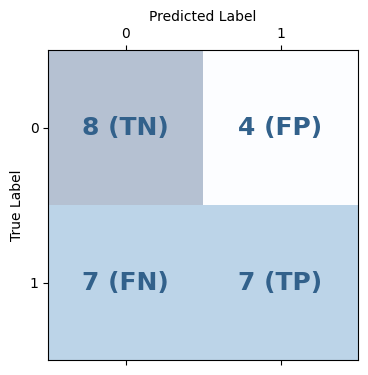

False Positive Rate (FPR): 0.333
Recall: 0.500
Negative Recall: 0.667
Precision: 0.636
F1 Score: 0.560
ROC AUC = 0.5476190476190476
Accuracy = 0.5769230769230769


In [ ]:
FPR, Recall, Negative_Recall, Precision, AUC, accuracy = all_results(bag_pipeline, X_test, y_train, y_test)


The feature importances are plotted below. Again, like with our decision tree model, the X1 and X3 features stand out as the most important features in our model. Therefore, it seems to be worthwhile to perform RFE on the bagging classifier, to see whether a equally good / better performing model with fewer features can be achieved.

Feature Importances:
  Feature  Importance
0      X1        0.26
2      X3        0.20
5      X6        0.15
4      X5        0.14
1      X2        0.13
3      X4        0.12


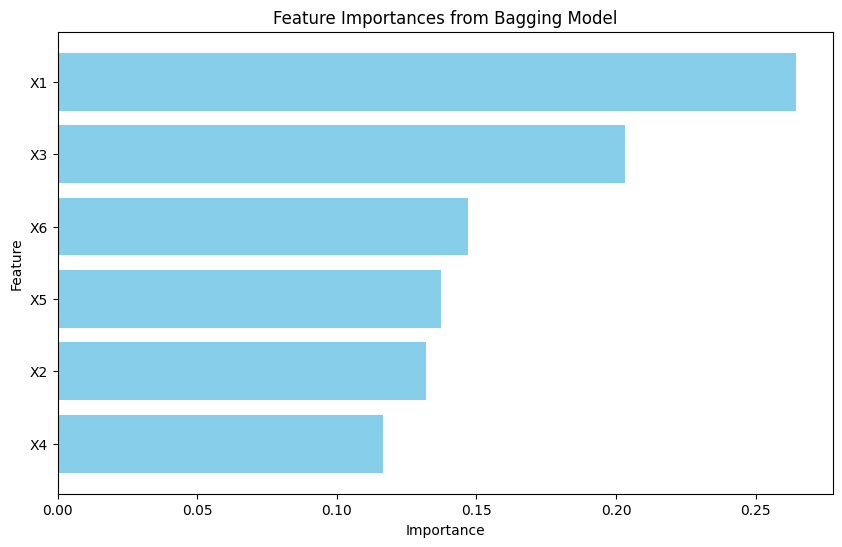

In [23]:
bagging_model = bag_pipeline.named_steps['model']

# Check if the base estimator has feature importances
if hasattr(bagging_model.estimators_[0], "feature_importances_"):
    # Average feature importances across all base estimators
    feature_importances = np.mean(
        [tree.feature_importances_ for tree in bagging_model.estimators_], axis=0
    )

    # Create a DataFrame for feature importance ranking
    importance_df = pd.DataFrame({
        "Feature": X_train.columns,
        "Importance": feature_importances
    }).sort_values(by="Importance", ascending=False)

    # Print feature rankings
    print("Feature Importances:")
    print(importance_df)

    # Visualize feature importances
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df["Feature"], importance_df["Importance"], color="skyblue")
    plt.gca().invert_yaxis()
    plt.title("Feature Importances from Bagging Model")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()
else:
    print("The base estimator does not support feature importances.")

AUC value: 0.5476190476190476


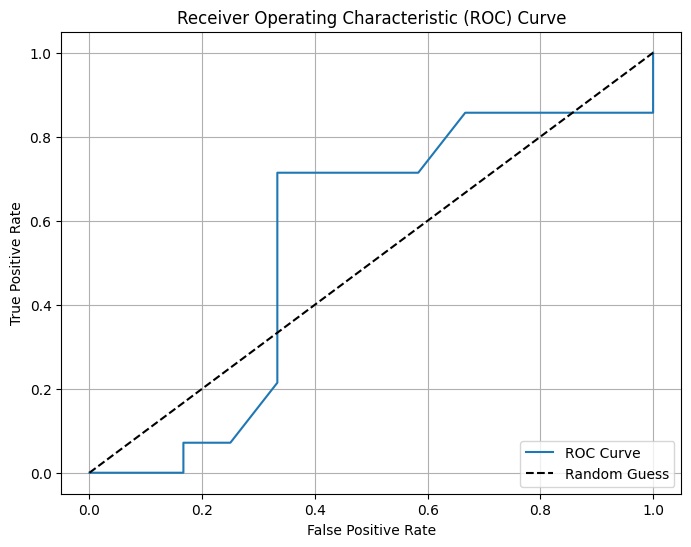

In [24]:
predictions_pa = bag_pipeline.predict_proba(X_test)

roc_calc = roc_curve(y_true = y_test, y_score = predictions_pa[:,1])
roc = pd.DataFrame(
    data = np.c_[roc_calc],
    columns = ('false positive rate', 'true positive rate', 'threshold')
)
print("AUC value:", roc_auc_score(y_true = y_test, y_score = predictions_pa[:,1]))

plot_roc_curve(roc)

#### RFE

Below are the results of the bagging classifier models with varying number of features. As we can see, models with only 2 and 1 features outperform the baseline model according to negative_recall scores. Therefore, it is worth our time to experiment with RFE. I will perform hyperparameter optimization, with number of features as a hyperparameter.

In [9]:
def bag_importance_getter(estimator):
    # Ensure the BaggingClassifier is fitted so that `estimators_` is available.
    # Average the feature importances from each decision tree.
    importances = np.array([tree.feature_importances_ for tree in estimator.estimators_])
    return np.mean(importances, axis=0)

              precision    recall  f1-score   support

           0       0.50      0.75      0.60        12
           1       0.62      0.36      0.45        14

    accuracy                           0.54        26
   macro avg       0.56      0.55      0.53        26
weighted avg       0.57      0.54      0.52        26



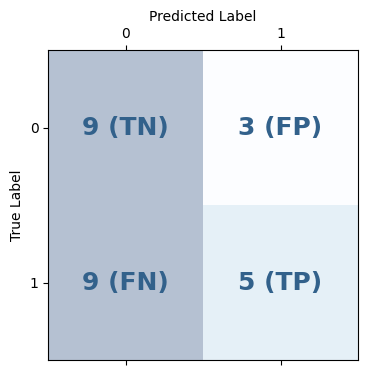

False Positive Rate (FPR): 0.250
Recall: 0.357
Negative Recall: 0.750
Precision: 0.625
F1 Score: 0.455
ROC AUC = 0.5714285714285714
Accuracy = 0.5384615384615384
              precision    recall  f1-score   support

           0       0.57      0.67      0.62        12
           1       0.67      0.57      0.62        14

    accuracy                           0.62        26
   macro avg       0.62      0.62      0.62        26
weighted avg       0.62      0.62      0.62        26



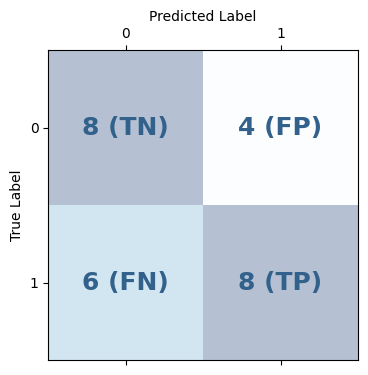

False Positive Rate (FPR): 0.333
Recall: 0.571
Negative Recall: 0.667
Precision: 0.667
F1 Score: 0.615
ROC AUC = 0.6071428571428572
Accuracy = 0.6153846153846154
              precision    recall  f1-score   support

           0       0.36      0.33      0.35        12
           1       0.47      0.50      0.48        14

    accuracy                           0.42        26
   macro avg       0.42      0.42      0.42        26
weighted avg       0.42      0.42      0.42        26



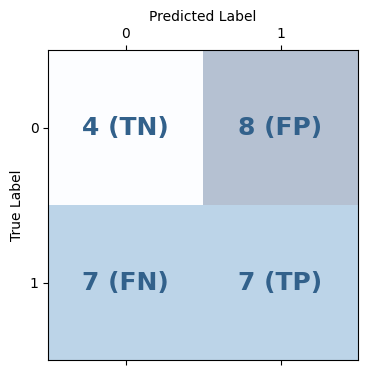

False Positive Rate (FPR): 0.667
Recall: 0.500
Negative Recall: 0.333
Precision: 0.467
F1 Score: 0.483
ROC AUC = 0.4821428571428571
Accuracy = 0.4230769230769231
              precision    recall  f1-score   support

           0       0.42      0.42      0.42        12
           1       0.50      0.50      0.50        14

    accuracy                           0.46        26
   macro avg       0.46      0.46      0.46        26
weighted avg       0.46      0.46      0.46        26



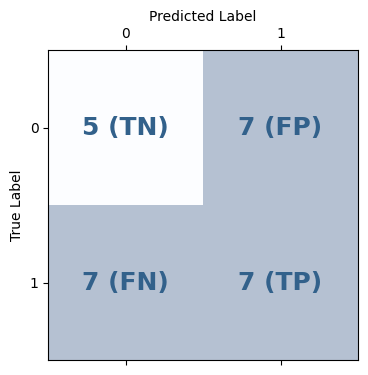

False Positive Rate (FPR): 0.583
Recall: 0.500
Negative Recall: 0.417
Precision: 0.500
F1 Score: 0.500
ROC AUC = 0.4910714285714286
Accuracy = 0.46153846153846156
              precision    recall  f1-score   support

           0       0.58      0.58      0.58        12
           1       0.64      0.64      0.64        14

    accuracy                           0.62        26
   macro avg       0.61      0.61      0.61        26
weighted avg       0.62      0.62      0.62        26



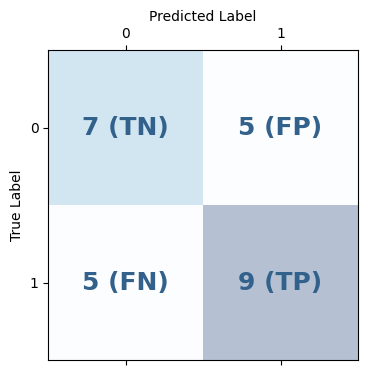

False Positive Rate (FPR): 0.417
Recall: 0.643
Negative Recall: 0.583
Precision: 0.643
F1 Score: 0.643
ROC AUC = 0.5863095238095237
Accuracy = 0.6153846153846154


,n_features,FPR,Recall,Negative Recall,Precision,ROC AUC,Accuracy
0,1,0.25,0.36,0.75,0.62,0.57,0.54
1,2,0.33,0.57,0.67,0.67,0.61,0.62
2,3,0.67,0.50,0.33,0.47,0.48,0.42
3,4,0.58,0.50,0.42,0.50,0.49,0.46
4,5,0.42,0.64,0.58,0.64,0.59,0.62


In [27]:
classifier_for_rfe = BaggingClassifier(estimator=DecisionTreeClassifier(random_state=seed))


n_features_arr = np.array([1,2,3,4,5])

rfe_results = pd.DataFrame(columns=['n_features','FPR','Recall', 'Negative Recall', 'Precision', 'ROC AUC', 'Accuracy'])

for i,n_feature in enumerate(n_features_arr):

    rfe = RFE(estimator=classifier_for_rfe, n_features_to_select=n_feature, importance_getter=bag_importance_getter)

    classifier_final = BaggingClassifier(estimator=DecisionTreeClassifier(random_state=seed))

    # Create a pipeline that first does feature selection, then classification
    pipeline = Pipeline(steps=[('rfe', rfe), ('clf', classifier_final)])

    pipeline.fit(X_train,y_train)

    FPR, Recall, Negative_Recall, Precision, AUC, accuracy = all_results(pipeline, X_test, y_train, y_test)

    row = {'n_features': n_feature, 'FPR': FPR,'Recall': Recall,'Negative Recall': Negative_Recall,'Precision': Precision,'ROC AUC': AUC,'Accuracy': accuracy }
    # Convert the row to a DataFrame and concatenate
    rfe_results = pd.concat([rfe_results, pd.DataFrame([row])], ignore_index=True)
rfe_results

Below we perform hyperparamater optimization, with number of features to select as one of our features.

In [51]:


def objective(params):
    # the number of features, ensuring it is an integer
    n_features = int(params['n_features'])

    bag_params = {
        "n_estimators": params['n_estimators'],    # single integer
        "max_samples": params['max_samples'],        # single float
        "max_features": params['max_features'],      # single float
        "bootstrap": params['bootstrap'],            # single boolean
        "random_state": params['random_state']       # seed value
    }
    
    dt_params = {
        "max_depth": params['dt_max_depth'],            # single integer
        "min_samples_split": params['dt_min_samples_split'],  # single integer
        "min_samples_leaf": params['dt_min_samples_leaf'],    # single integer
        "criterion": params['dt_criterion'],            # single string
        "class_weight": params['dt_class_weight']       # either None or "balanced"
    }


    classifier_for_rfe = BaggingClassifier(
        estimator=DecisionTreeClassifier(**dt_params),
        **bag_params
    )

    rfe = RFE(estimator=classifier_for_rfe, 
                n_features_to_select=n_features,
                importance_getter=bag_importance_getter)

    classifier_final = BaggingClassifier(
            estimator=DecisionTreeClassifier(**dt_params),
            **bag_params
        )
        # Create a pipeline that first does feature selection, then classification
    bag_pipeline = Pipeline(steps=[('rfe', rfe), 
                    ('model', classifier_final)])
    # Use cross-validation to evaluate performance using negative recall
    score = cross_val_score(bag_pipeline, X_train, y_train, scoring=negative_recall, cv=5).mean()
    
    # Hyperopt minimizes the objective, so return the negative score (to maximize negative recall)
    return {'loss': -score, 'status': STATUS_OK}


# Define the hyperparameter search space using hp.choice for discrete parameters
search_space = {
    # number of features
    'n_features': hp.choice('n_features', list(np.arange(1, 7, 1, dtype=int))),
    # bagging hyperparams
    'n_estimators' : hp.choice('n_estimators', list(np.arange(10, 100, 10, dtype=int))),
    'max_samples' : hp.choice('max_samples', [0.5, 0.7, 1.0]),
    'max_features' : hp.choice('max_features', [1.0]),
    'bootstrap' : hp.choice('bootstrap', [True, False]),
    'random_state' : hp.choice('random_state', [7980]),
    # decision tree hyperparams
    'dt_max_depth' : hp.choice('dt_max_depth', list(np.arange(7, 14, 1, dtype=int))),
    'dt_min_samples_split' : hp.choice('dt_min_samples_split', list(np.arange(4, 10, 1, dtype=int))),
    'dt_min_samples_leaf' : hp.choice('dt_min_samples_leaf', list(np.arange(1, 4, 1, dtype=int))),
    'dt_criterion' : hp.choice('dt_criterion', ['gini','entropy']),
    'dt_class_weight' : hp.choice('dt_class_weight', [None, "balanced"])

}
trials = Trials()
best = fmin(
    fn = objective,
    space = search_space,
    algo = tpe.suggest,
    max_evals=500,
    trials = trials
)

best_params = space_eval(search_space, best)
print("Best hyperparameters:", best_params)

100%|██████████| 500/500 [1:25:58<00:00, 10.32s/trial, best loss: -0.6888888888888889]
Best hyperparameters: {'bootstrap': False, 'dt_class_weight': 'balanced', 'dt_criterion': 'gini', 'dt_max_depth': np.int64(12), 'dt_min_samples_leaf': np.int64(2), 'dt_min_samples_split': np.int64(5), 'max_features': 1.0, 'max_samples': 0.7, 'n_estimators': np.int64(30), 'n_features': np.int64(2), 'random_state': 7980}


In [10]:
best_params = {'bootstrap': False, 'dt_class_weight': 'balanced', 'dt_criterion': 'gini', 'dt_max_depth': np.int64(12), 'dt_min_samples_leaf': np.int64(2), 'dt_min_samples_split': np.int64(5), 'max_features': 1.0, 'max_samples': 0.7, 'n_estimators': np.int64(30), 'n_features': np.int64(2), 'random_state': 7980}

dt_params = {k: v for k, v in best_params.items() if k.startswith('dt_')}
dt_params = {
    (k[len('dt_'):] if k.startswith('dt_') else k): v
    for k, v in dt_params.items()
}

bag_params = {k: v for k, v in best_params.items() if not k.startswith('dt_')}
n_features = int(bag_params['n_features'])
del bag_params['n_features']



classifier_for_rfe = BaggingClassifier(
        estimator=DecisionTreeClassifier(**dt_params),
        **bag_params
    )

rfe = RFE(estimator=classifier_for_rfe, 
              n_features_to_select=n_features,
              importance_getter=bag_importance_getter)

classifier_final = BaggingClassifier(
        estimator=DecisionTreeClassifier(**dt_params),
        **bag_params
    )
    # Create a pipeline that first does feature selection, then classification
bag_pipeline = Pipeline(steps=[('rfe', rfe), 
                ('model', classifier_final)])

bag_pipeline.fit(X_train,y_train)

mask = bag_pipeline.named_steps['rfe'].support_
selected_feature_names_bag = X_train.columns[mask]
print("Selected features:", selected_feature_names_bag)


Selected features: Index(['X1', 'X3'], dtype='object')


Below I have plotted feature importance. As can be seen, the model only has two features, X3 and X1. This echoes our findings from the decision tree model section, where we also saw that these two features were by far the most important features in that model.

Feature Importances:
  Feature  Importance
1      X3        0.53
0      X1        0.47


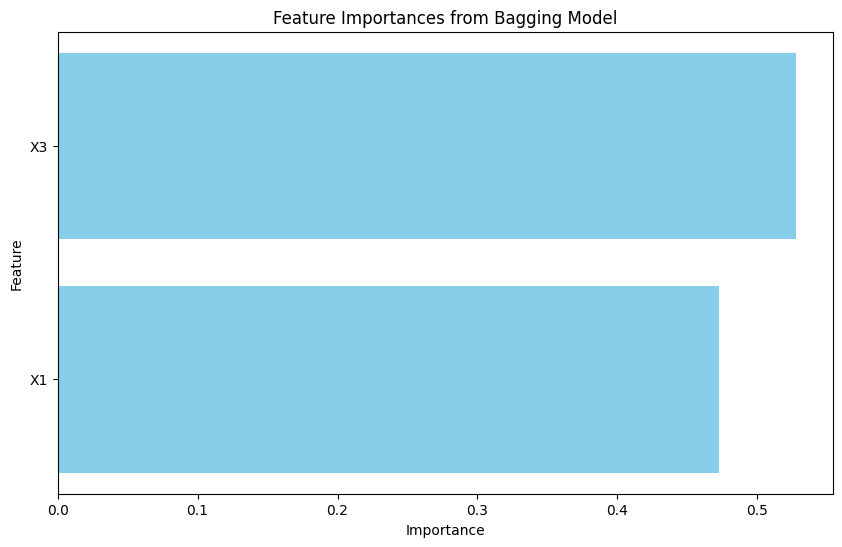

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Extract the BaggingClassifier from the pipeline
bagging_model = bag_pipeline.named_steps["model"]

# Check if the base estimator has feature importances
if hasattr(bagging_model.estimators_[0], "feature_importances_"):
    # Average feature importances across all base estimators
    feature_importances = np.mean(
        [tree.feature_importances_ for tree in bagging_model.estimators_], axis=0
    )

    # Create a DataFrame for feature importance ranking
    importance_df = pd.DataFrame({
        "Feature": selected_feature_names_bag,
        "Importance": feature_importances
    }).sort_values(by="Importance", ascending=False)

    # Print feature rankings
    print("Feature Importances:")
    print(importance_df)

    # Visualize feature importances
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df["Feature"], importance_df["Importance"], color="skyblue")
    plt.gca().invert_yaxis()
    plt.title("Feature Importances from Bagging Model")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()
else:
    print("The base estimator does not support feature importances.")


Below is the ROC curve for this model.

AUC value: 0.6101190476190477


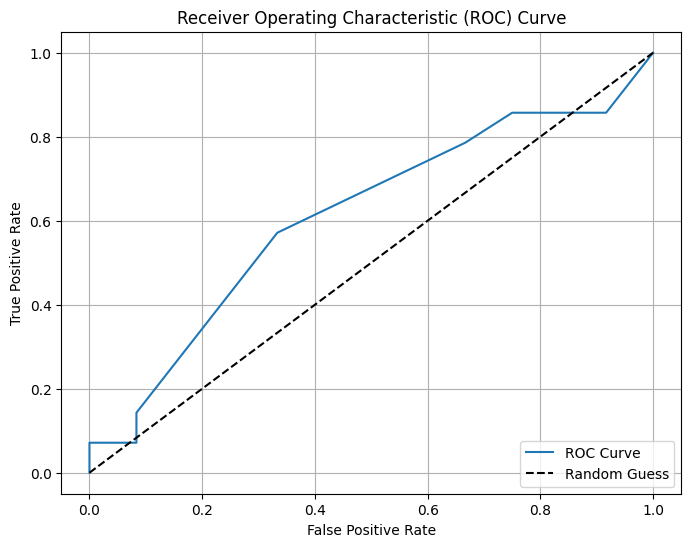

In [12]:
predictions_pa = bag_pipeline.predict_proba(X_test)

roc_calc = roc_curve(y_true = y_test, y_score = predictions_pa[:,1])
roc = pd.DataFrame(
    data = np.c_[roc_calc],
    columns = ('false positive rate', 'true positive rate', 'threshold')
)
print("AUC value:", roc_auc_score(y_true = y_test, y_score = predictions_pa[:,1]))

# Compute precision-recall curve
baseline_precision, baseline_recall, thresholds = precision_recall_curve(y_test, predictions_pa[:,1])

# Compute area under the curve (AUC)
baseline_auc_score = auc(baseline_recall, baseline_precision)

plot_roc_curve(roc)

Below, is the confusion matrix for the model results on the test data. As can be seen, the model classifies 67% of the negative cases correctly. Thus, it performs fairly well at classifying negative cases. It performs less well at classifying positive cases (recall of 57%). Therefore, we can note that the bagging classifier does not offer a substantial improvement on the decision tree model.

              precision    recall  f1-score   support

           0       0.57      0.67      0.62        12
           1       0.67      0.57      0.62        14

    accuracy                           0.62        26
   macro avg       0.62      0.62      0.62        26
weighted avg       0.62      0.62      0.62        26



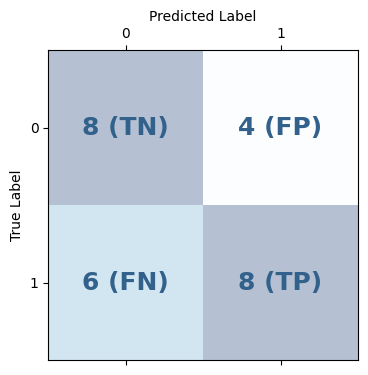

False Positive Rate (FPR): 0.333
Recall: 0.571
Negative Recall: 0.667
Precision: 0.667
F1 Score: 0.615
ROC AUC = 0.6101190476190477
Accuracy = 0.6153846153846154


In [16]:
FPR, Recall, Negative_Recall, Precision, AUC, accuracy = all_results(bag_pipeline, X_test, y_train, y_test)


Scores

seed = 7980

- negative recall: X2 only feature. False Positive Rate (FPR): 0.250, Recall: 0.500, Negative Recall: 0.750, Precision: 0.700, F1 Score: 0.583, accuracy 0.64
- accuracy: False Positive Rate (FPR): 0.417, Recall: 0.357, Negative Recall: 0.583, Precision: 0.500, F1 Score: 0.417
- f1: False Positive Rate (FPR): 0.167, Recall: 0.571, Negative Recall: 0.833, Precision: 0.800, F1 Score: 0.667, accuracy = 0.72
- negative precision: False Positive Rate (FPR): 0.333, Recall: 0.357, Negative Recall: 0.667, Precision: 0.556, F1 Score: 0.435, accuracy = 0.52.

seed = 9329

- negative recall : False Positive Rate (FPR): 0.083, Recall: 0.071, Negative Recall: 0.917, Precision: 0.500, F1 Score: 0.125, ROC AUC = 0.46130952380952384, Accuracy = 0.46153846153846156


##### Analysis of Results of Bagging Classifier Model

In this section, we experimented with the bagging classifier ensemble method. We found that the model performed equally as well as the decision tree model. Therefore the ensemble method did not provide any improvement on the decision tree model. Furthermore, we found that, again, the X1 and X3 features stood out as the most important features in the model.

### **Naive Bayes Classifiers**


From our analysis of the Lazy predict results, BernoulliNB classifier came up as a recommended model. However, this model assumes our features are binary. As they are not, it makes more sense to use the MultinomialNB classifier, which assumes our features take integer values. 

##### **MultinomialNB**

We start by trying out the MultinomialNB with default parameters. The results are given below. As we can see, the model classifies all test points as positive, which is clearly not what we want. Let's try optimizing for hyperparameters. Note, we do not attempt RFE here, as Naive Bayes classifiers do not have functions that estimate relative importance of each feature in the model.

In [18]:
from sklearn.naive_bayes import MultinomialNB

classifier_final = MultinomialNB()
pipeline_mnb_baseline = Pipeline(steps=[('clf', classifier_final)])


pipeline_mnb_baseline.fit(X_train,y_train)


Pipeline(steps=[('clf', MultinomialNB())])

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.54      1.00      0.70        14

    accuracy                           0.54        26
   macro avg       0.27      0.50      0.35        26
weighted avg       0.29      0.54      0.38        26



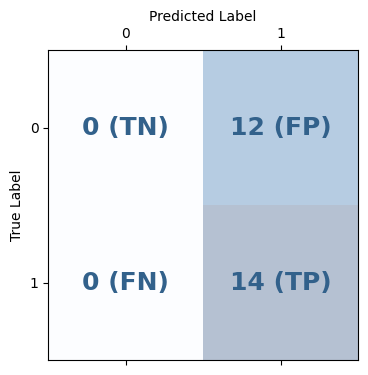

False Positive Rate (FPR): 1.000
Recall: 1.000
Negative Recall: 0.000
Precision: 0.538
F1 Score: 0.700
ROC AUC = 0.7708333333333334
Accuracy = 0.5384615384615384


In [23]:
FPR, Recall, Negative_Recall, Precision, AUC, accuracy = all_results(pipeline_mnb_baseline, X_test, y_train, y_test)

Below, we implement hyperparameter optimization.

In [ ]:
from sklearn.naive_bayes import MultinomialNB



def objective(params):


    bern_params = {
        'alpha': params['alpha'],
        'fit_prior': params['fit_prior']
    
    }

    # Create an instance for RFE


    # Create a new instance for the final classifier
    classifier_final = MultinomialNB(**bern_params)
    pipeline = Pipeline(steps=[('clf', classifier_final)])

    # Use cross-validation to evaluate performance using negative recall
    score = cross_val_score(pipeline, X_train, y_train, scoring=negative_precision, cv=5).mean()
    
    # Hyperopt minimizes the objective, so return the negative score (to maximize negative recall)
    return {'loss': -score, 'status': STATUS_OK}

search_space = {
    'alpha': hp.loguniform('alpha', -5, 1),  # alpha in range ~[0.006, 2.7]
    'fit_prior': hp.choice('fit_prior', [True, False])  # Whether to learn prior

}

trials = Trials()
best = fmin(
    fn = objective,
    space = search_space,
    algo = tpe.suggest,
    max_evals=1000,
    trials = trials
)

best_params = space_eval(search_space, best)
print("Best hyperparameters:", best_params)



100%|██████████| 1000/1000 [01:03<00:00, 15.63trial/s, best loss: -0.38863636363636367]
Best hyperparameters: {'alpha': 0.12237187703903857, 'fit_prior': False}


In [48]:
mult_params = {'alpha': 0.12237187703903857, 'fit_prior': False}


# Create a new instance for the final classifier
classifier_final = MultinomialNB(**mult_params)
mult_pipeline = Pipeline(steps=[('clf', classifier_final)])

mult_pipeline.fit(X_train,y_train)


Pipeline(steps=[('clf',
                 MultinomialNB(alpha=0.12237187703903857, fit_prior=False))])

Below are the results using optimized hyperparameters. As we can see, the model is vastly improved. The model correctly classifies unhappy customers 67% of the time, and happy customers 64% of the time. The accuracy of the model is 66%. Thus, this model is the most accurate model we have worked with so far, outperforming the decision tree and bagging classifier models with a reduced feature space according to the accuracy score. However, the decision tree model still outperforms this model according to the negative recall score.

              precision    recall  f1-score   support

           0       0.62      0.67      0.64        12
           1       0.69      0.64      0.67        14

    accuracy                           0.65        26
   macro avg       0.65      0.65      0.65        26
weighted avg       0.66      0.65      0.65        26



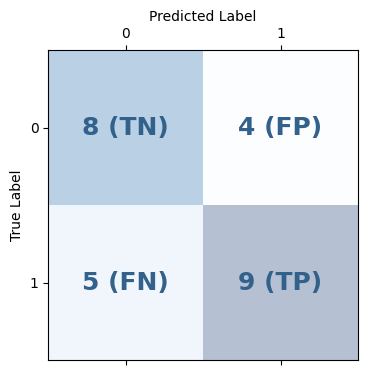

False Positive Rate (FPR): 0.333
Recall: 0.643
Negative Recall: 0.667
Precision: 0.692
F1 Score: 0.667
ROC AUC = 0.7708333333333334
Accuracy = 0.6538461538461539


In [26]:
FPR, Recall, Negative_Recall, Precision, AUC, accuracy = all_results(mult_pipeline, X_test, y_train, y_test)

with rfe
- negative_recall : all are classified as negative
- accuracy : all classifed as positive

without rfe

- negative recall: False Positive Rate (FPR): 0.333, Recall: 0.643, Negative Recall: 0.667, Precision: 0.692, F1 Score: 0.667, accuracy = 0.66, auc = 0.77
- accuracy : all classifed as positive
- f1: all classified as positive
- negative precision: False Positive Rate (FPR): 0.333, Recall: 0.643, Negative Recall: 0.667, Precision: 0.692, F1 Score: 0.667, accuracy = 0.66, auc = 0.77


ROC Curve for model.

AUC value: 0.7708333333333334


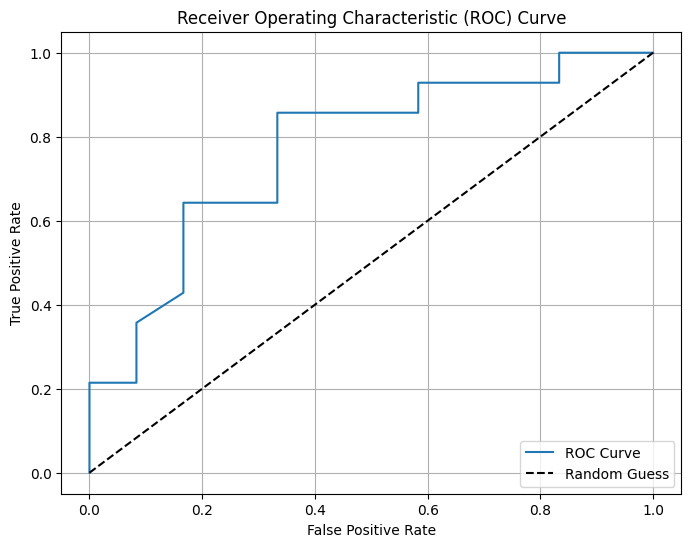

In [ ]:
predictions_pa = mult_pipeline.predict_proba(X_test)

roc_calc = roc_curve(y_true = y_test, y_score = predictions_pa[:,1])
roc = pd.DataFrame(
    data = np.c_[roc_calc],
    columns = ('false positive rate', 'true positive rate', 'threshold')
)
print("AUC value:", roc_auc_score(y_true = y_test, y_score = predictions_pa[:,1]))

plot_roc_curve(roc)

##### Analysis of Results of MultinomialNB Model

We have found that a MultinomialNB Model can outperform our decision tree and bagging classifier model, both of which were working in a reduced feature space. Therefore, a model using all features can perform relatively well. Unfortunately, MultinomialNB Model does not offer a framework which allows us to quantify the relative feature importance in the model. Therefore, no conclusions as to what features are most important for predicting customer satisfaction can be gained from this model. 

### **Logistic Regression**

Below are the results for a logistic regression model with default hyperparameters. We can see that the model performs fairly well, correctly predicting unhappy customers 67% of the time and happy customers 57% of the time. 

In [28]:
classifier_final = LogisticRegression()
pipeline_log_baseline = Pipeline(steps=[ ('clf', classifier_final)])
pipeline_log_baseline.fit(X_train,y_train)


Pipeline(steps=[('clf', LogisticRegression())])

              precision    recall  f1-score   support

           0       0.57      0.67      0.62        12
           1       0.67      0.57      0.62        14

    accuracy                           0.62        26
   macro avg       0.62      0.62      0.62        26
weighted avg       0.62      0.62      0.62        26



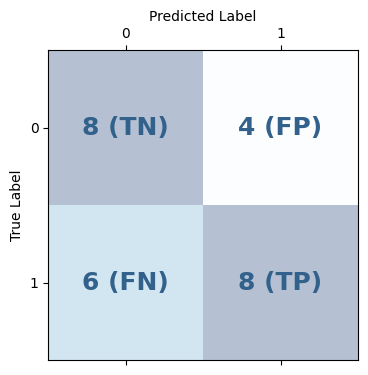

False Positive Rate (FPR): 0.333
Recall: 0.571
Negative Recall: 0.667
Precision: 0.667
F1 Score: 0.615
ROC AUC = 0.6815476190476191
Accuracy = 0.6153846153846154


In [29]:
FPR, Recall, Negative_Recall, Precision, AUC, accuracy = all_results(pipeline_log_baseline, X_test, y_train, y_test)

The coefficients of the features are plotted below. We first note that all coefficients are positive. Therefore, a higher value of each of our features is correllated with a higher probability of our customer being happy. Furthermore, the feature X1 is by far the most influential feature.  

Coefficients of the best logistic regression model:
[0.6100185  0.05878226 0.03426459 0.03335377 0.09001045 0.06983195]
Intercept of the best logistic regression model:
[-3.45320881]


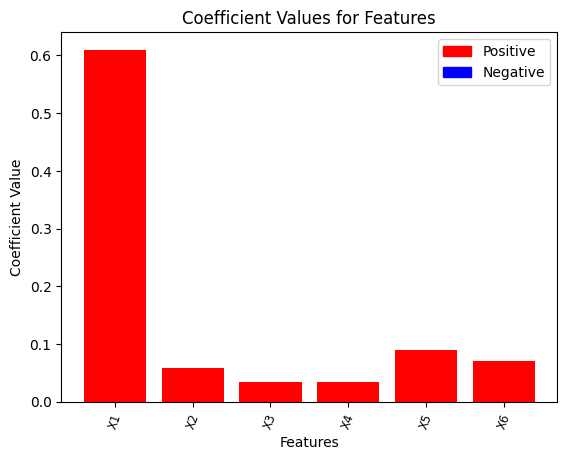

In [32]:
coefficients = pipeline_log_baseline.named_steps['clf'].coef_[0]
print("Coefficients of the best logistic regression model:")
print(coefficients)
print('Intercept of the best logistic regression model:')
print(pipeline_log_baseline.named_steps['clf'].intercept_)

plot_coefs(coefficients, X_train.columns, 'Coefficient Values for Features')


The ROC curve is plotted below.

AUC value: 0.6309523809523809


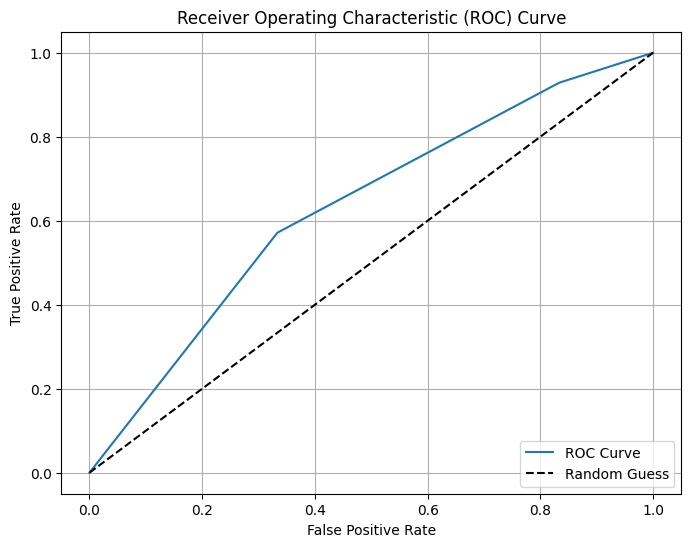

In [ ]:
predictions_pa = pipeline_log_baseline.predict_proba(X_test)

roc_calc = roc_curve(y_true = y_test, y_score = predictions_pa[:,1])
roc = pd.DataFrame(
    data = np.c_[roc_calc],
    columns = ('false positive rate', 'true positive rate', 'threshold')
)
print("AUC value:", roc_auc_score(y_true = y_test, y_score = predictions_pa[:,1]))

# Compute precision-recall curve
baseline_precision, baseline_recall, thresholds = precision_recall_curve(y_test, predictions_pa[:,1])

# Compute area under the curve (AUC)
baseline_auc_score = auc(baseline_recall, baseline_precision)

plot_roc_curve(roc)

##### Analysis of Results of Logistic Regression Model

In this section we have seen that a logistic regression model with a full feature space can be constructed which performs fairly accurately. Furthermore, the X1 feature is by far the most influential feature in this model. Thus, we have again seen that the X1 feature stands out as significant for predicting customer satisfaction.

### **Ensemble Methods**

In this exploration, we have worked with different models, and we have seen that they offer relative strengths and weaknesses; the decision tree model predicts negative cases very well, but positive cases quite poorly, while the Multinomial Naive Bayes and logistic regression models provide a more balanced approach, predicting both negative and positive cases fairly well but not brilliantly. Therefore, it makes sense to combine these models in an ensemble method, to combine their relative strengths. Here, we will use a voting ensemble method with soft voting.

In [ ]:

## DTC

best_params_dtc = {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': np.int64(3), 'min_samples_leaf': np.int64(1), 'min_samples_split': np.int64(5), 'n_features': np.int64(3), 'random_state': 9329}

n_features_dtc = int(best_params_dtc['n_features'])
del best_params_dtc['n_features']



classifier_for_rfe = DecisionTreeClassifier(**best_params_dtc)
    
# Set up the RFE with the classifier as the estimator
rfe = RFE(estimator=classifier_for_rfe, n_features_to_select=n_features_dtc)



# Create a pipeline that first does feature selection, then classification
dtc_pipeline = Pipeline(steps=[('rfe', rfe), ('clf', DecisionTreeClassifier(**best_params_dtc))])


## MultinomialNB

mult_params = {'alpha': 0.12237187703903857, 'fit_prior': False}


# Create a new instance for the final classifier
mult_pipeline = Pipeline(steps=[('clf', MultinomialNB(**mult_params))])

## Logistic Regression

log_pipeline = Pipeline(steps=[ ('clf', LogisticRegression())])

estimators = [('dtc',dtc_pipeline),('nb', mult_pipeline),('log',log_pipeline)]

The results for the soft voting ensemble method are given below. As we can see, the model outperforms all of our models that we have seen so far, according to all scores. The model correctly classifies negative cases 91.7% of the time and positive cases 57% of the time. Thus, the overall accuracy of the model is 73%.

In [45]:

vote_clf = VotingClassifier(
    estimators=estimators, voting='soft'
)

vote_clf.fit(X_train, y_train)


VotingClassifier(estimators=[('dtc',
                              Pipeline(steps=[('rfe',
                                               RFE(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                                                    criterion='entropy',
                                                                                    max_depth=np.int64(3),
                                                                                    min_samples_leaf=np.int64(1),
                                                                                    min_samples_split=np.int64(5),
                                                                                    random_state=9329),
                                                   n_features_to_select=3)),
                                              ('clf',
                                               DecisionTreeClassifier(class_weight='balanced',
                                                                      criterion='entropy',
                                                                      max_depth=np.int64(3),
                                                                      min_samples_leaf=np.int64(1),
                                                                      min_samples_split=np.int64(5),
                                                                      random_state=9329))])),
                             ('multNB',
                              Pipeline(steps=[('clf',
                                               MultinomialNB(alpha=0.12237187703903857,
                                                             fit_prior=False))])),
                             ('log',
                              Pipeline(steps=[('clf', LogisticRegression())]))],
                 voting='soft')

              precision    recall  f1-score   support

           0       0.65      0.92      0.76        12
           1       0.89      0.57      0.70        14

    accuracy                           0.73        26
   macro avg       0.77      0.74      0.73        26
weighted avg       0.78      0.73      0.72        26



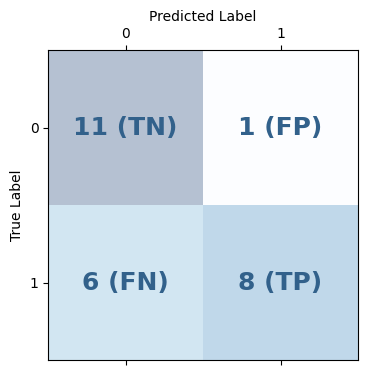

False Positive Rate (FPR): 0.083
Recall: 0.571
Negative Recall: 0.917
Precision: 0.889
F1 Score: 0.696
ROC AUC = 0.7291666666666666
Accuracy = 0.7307692307692307


In [46]:
FPR, Recall, Negative_Recall, Precision, AUC, accuracy = all_results(vote_clf, X_test, y_train, y_test)

### **Conclusion and Evaluation**

In this project, we have examined a number of classification models. Each had their own strengths and weaknesses. The decision tree model predicts negative cases very well, but positive cases quite poorly, while the Multinomial Naive Bayes and logistic regression models provide a more balanced approach, predicting both negative and positive cases fairly well but not brilliantly. We then combined these models using a voting ensemble method, and found that this model took advantage of the strengths of the individual models well. The voting ensemble method performed very well, correctly classifying unhappy customers 91.7% of the time, and yielded an overall accuracy of 73%. Thus, we will present this ensemble method model as our final model.

In this exploration, we have gained insights into relative importance of the features in our dataset. Throughout the exploration, the X1 feature consistently appeared to be significant for estimating customer satisfaction. Thus, we can make a recommendation to the company to make on-time delivery an essential goal for the future. Furthermore, throughout the exploration, we noted the relative absence of the X2 and X4 features in our models. Therefore, it appears that these features do not affect customer satisfaction very much. We recommend that future surveys ommit these features from the questionaire. 